# Nadaraya-Waston Kernel Regression

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### Generating Dataset

In [2]:
n_train = 50  # number of training samples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # sorted training samples

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # output of training samples
x_test = torch.arange(0, 5, 0.1)  # testing samples
y_truth = f(x_test)  # real output of testing samples
n_test = len(x_test)  # number of testing samples
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### Average Pooling

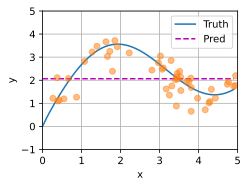

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### Nonparametric attention pooling

Nadaraya-Watson kernel regression

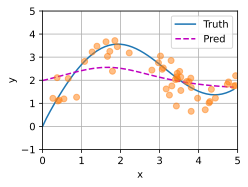

In [5]:
# X_repeat shape:(n_test, n_train),
# same testing input for each row (eg. same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train contains keys. attention_weights shape: (n_test, n_train),
# attention weight of y_train for reach row
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# each entry of y_hat is weighted average, weight is attention weight
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

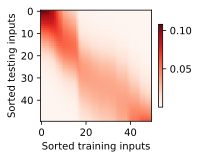

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### Parametric attention pooling

tensor of size (n, a, b) multiply tensor of size (n, b, c) = tensor of size (n, a, c)

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

#### Define the Model

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries/attention_weights shape: (number of queries, number of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values shape: (number of queries, number of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

#### Training

In [10]:
# X_tile shape:(n_train，n_train)，each row contains same training samples
X_tile = x_train.repeat((n_train, 1))
# Y_tile shape:(n_train，n_train)，each row contains same outputs
Y_tile = y_train.repeat((n_train, 1))
# keys shape:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values shape:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

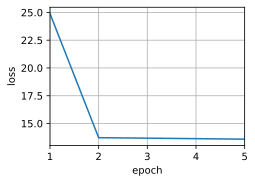

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

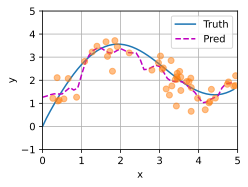

In [12]:
# keys shape: (n_test，n_train)，each row contains same training samples (eg. same keys)
keys = x_train.repeat((n_test, 1))
# value shape: (n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

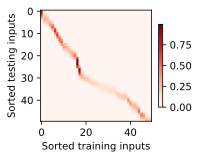

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

The line around larger weights is not smooth.